In [1]:
from utils import *

In [2]:
spec_type = 'linear_linear'
dir_name = f'22k_2sec_better_centered_{spec_type}'

In [3]:
NUM_WORKERS=12
BS=64

item_img_tfms = [ToTensor()]
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dsrc = get_datasource(dir_name)
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=BS, num_workers=NUM_WORKERS)

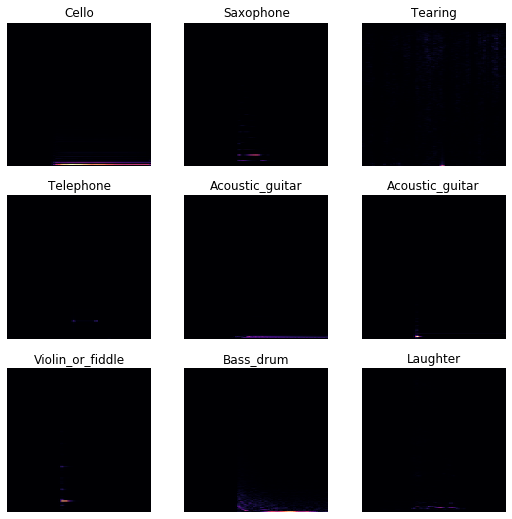

In [4]:
dbch.show_batch(max_n=9)

In [5]:
for split_idx in range(5):
    dsrc = get_datasource(dir_name, split_idx=split_idx)
    dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=BS, num_workers=NUM_WORKERS)
    
    learn = get_learner(dbch)
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(10, slice(6e-4, 6e-2))
    
    preds, targs = learn.get_preds()
    torch.save(preds, f'data/preds/val/{spec_type}_{split_idx}')
            
    tst_paths = list(Path(f'data/img_test_{dir_name}/').iterdir())
    test_preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]
    torch.save(test_preds, f'data/preds/test/{spec_type}_{split_idx}')    

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.680927,2.250560,0.452938,0.685387,00:50
1,1.907795,1.833679,0.514821,0.736349,00:46
2,1.373813,1.581761,0.569423,0.765471,00:45
3,0.859795,1.485835,0.609464,0.798232,00:45
4,0.576835,1.466098,0.612064,0.799272,00:46


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.076840,2.627862,0.387415,0.622985,01:04
1,1.857430,2.588461,0.325013,0.576183,01:02
2,2.026527,2.999427,0.393656,0.597504,01:02
3,2.001170,4.078574,0.247530,0.374415,01:02
4,1.721701,2.748317,0.380135,0.550702,01:02
5,1.510386,2.637704,0.320853,0.581903,01:02
6,1.017712,2.039075,0.561622,0.741550,01:02
7,0.582643,1.895336,0.578783,0.760270,01:02
8,0.307194,3.108771,0.720229,0.869995,01:04
9,0.162927,1.147735,0.762870,0.894436,01:04


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.660128,2.171513,0.459686,0.676440,00:48
1,1.882459,1.741705,0.537696,0.743455,00:46
2,1.331501,1.582844,0.574346,0.786387,00:46
3,0.855746,1.465815,0.599476,0.797382,00:46
4,0.578012,1.456315,0.611518,0.802094,00:46


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.100288,2.916177,0.357592,0.569110,01:03
1,1.892447,2.535575,0.372251,0.582722,01:03
2,2.125606,3.510118,0.248691,0.433508,01:03
3,2.006424,3.189067,0.301047,0.499476,01:03
4,1.723009,2.822299,0.542408,0.749738,01:03
5,1.377437,3.595489,0.363351,0.554450,01:03
6,1.049094,6.006095,0.371204,0.548168,01:03
7,0.610081,1.231711,0.717277,0.871728,01:03
8,0.312872,2.383934,0.757068,0.895811,01:04
9,0.165989,1.205598,0.770681,0.902094,01:04


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.650446,2.291633,0.431062,0.659799,00:47
1,1.879341,1.882143,0.505547,0.731643,00:46
2,1.296228,1.682770,0.559958,0.769678,00:46
3,0.854941,1.588673,0.580032,0.790280,00:46
4,0.563244,1.557973,0.595351,0.788167,00:46


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.073932,3.114758,0.291601,0.504490,01:03
1,1.797750,3.344809,0.243001,0.400423,01:04
2,2.119070,5.826105,0.090333,0.176968,01:03
3,2.254401,4.547374,0.119387,0.241416,01:03
4,2.117861,2.424786,0.395140,0.637612,01:03
5,1.516330,36.611843,0.454305,0.643423,01:03
6,1.072166,1.614483,0.578447,0.774432,01:03
7,0.725549,2.284437,0.637084,0.796619,01:04
8,0.403883,2.823461,0.717380,0.856313,01:03
9,0.237849,3.728853,0.707343,0.864237,01:03


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.692101,2.044747,0.466808,0.702602,00:47
1,1.915835,1.661121,0.540096,0.764737,00:46
2,1.351953,1.515221,0.587892,0.790759,00:46
3,0.877307,1.418451,0.613383,0.809878,00:46
4,0.613816,1.395577,0.618694,0.809878,00:46


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.070233,2.710558,0.323420,0.546468,01:03
1,1.887001,3.361664,0.227297,0.375465,01:03
2,2.151921,2.879220,0.372278,0.582581,01:03
3,1.967452,2.542933,0.482740,0.652151,01:03
4,1.764190,3.994637,0.381837,0.597451,01:03
5,1.287068,2.834627,0.477430,0.642592,01:04
6,0.977313,1.595116,0.617631,0.794477,01:03
7,0.565151,1.991109,0.548062,0.736059,01:04
8,0.254054,1.158212,0.749336,0.883696,01:03
9,0.124984,1.133670,0.763144,0.887414,01:03


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.686728,2.172993,0.445815,0.682940,00:47
1,1.874280,1.735810,0.537017,0.762339,00:46
2,1.326748,1.614845,0.562768,0.793455,00:46
3,0.876773,1.519763,0.609442,0.799893,00:46
4,0.568230,1.498591,0.613734,0.809013,00:46


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.120941,3.395223,0.332618,0.562232,01:03
1,1.851427,3.059270,0.275215,0.475858,01:03
2,2.100065,3.548699,0.196352,0.369635,01:03
3,2.004784,4.300928,0.244099,0.421674,01:03
4,1.700405,3.805416,0.239270,0.447961,01:03
5,1.271858,3.368701,0.266631,0.434549,01:03
6,0.873236,2.123551,0.505365,0.691524,01:03
7,0.525892,1.297674,0.709764,0.860515,01:03
8,0.231089,1.251048,0.734979,0.868562,01:03
9,0.105754,1.117330,0.762876,0.894313,01:03


In [6]:
preds = [torch.load(f'data/preds/test/{spec_type}_{split_idx}') for split_idx in range(5)]
preds = torch.stack(preds).mean(0)

In [7]:
create_submission_and_submit(None, dbch, name(), dir_name, preds)

wipzoefsdm


In [8]:
val_preds = [torch.load(f'data/preds/val/{spec_type}_{split_idx}') for split_idx in range(5)]
val_preds = torch.cat(val_preds)
top_3_accuracy(val_preds, val_targs)

tensor(0.8883)